In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!python -m pip install pyyaml==5.1
# Detectron2 has not released pre-built binaries for the latest pytorch (https://github.com/facebookresearch/detectron2/issues/4053)
# so we install from source instead. This takes a few minutes.
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

# Install pre-built detectron2 that matches pytorch version, if released:
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/{CUDA_VERSION}/{TORCH_VERSION}/index.html

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also r

  Using cached PyYAML-5.1.tar.gz (274 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-ogjttwyf
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-ogjttwyf
  Resolved https://github.com/facebookresearch/detectron2.git to commit 864913f0e57e87a75c8cc0c7d79ecbd774fc669b
  Preparing metadata (setup.py) ... done


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


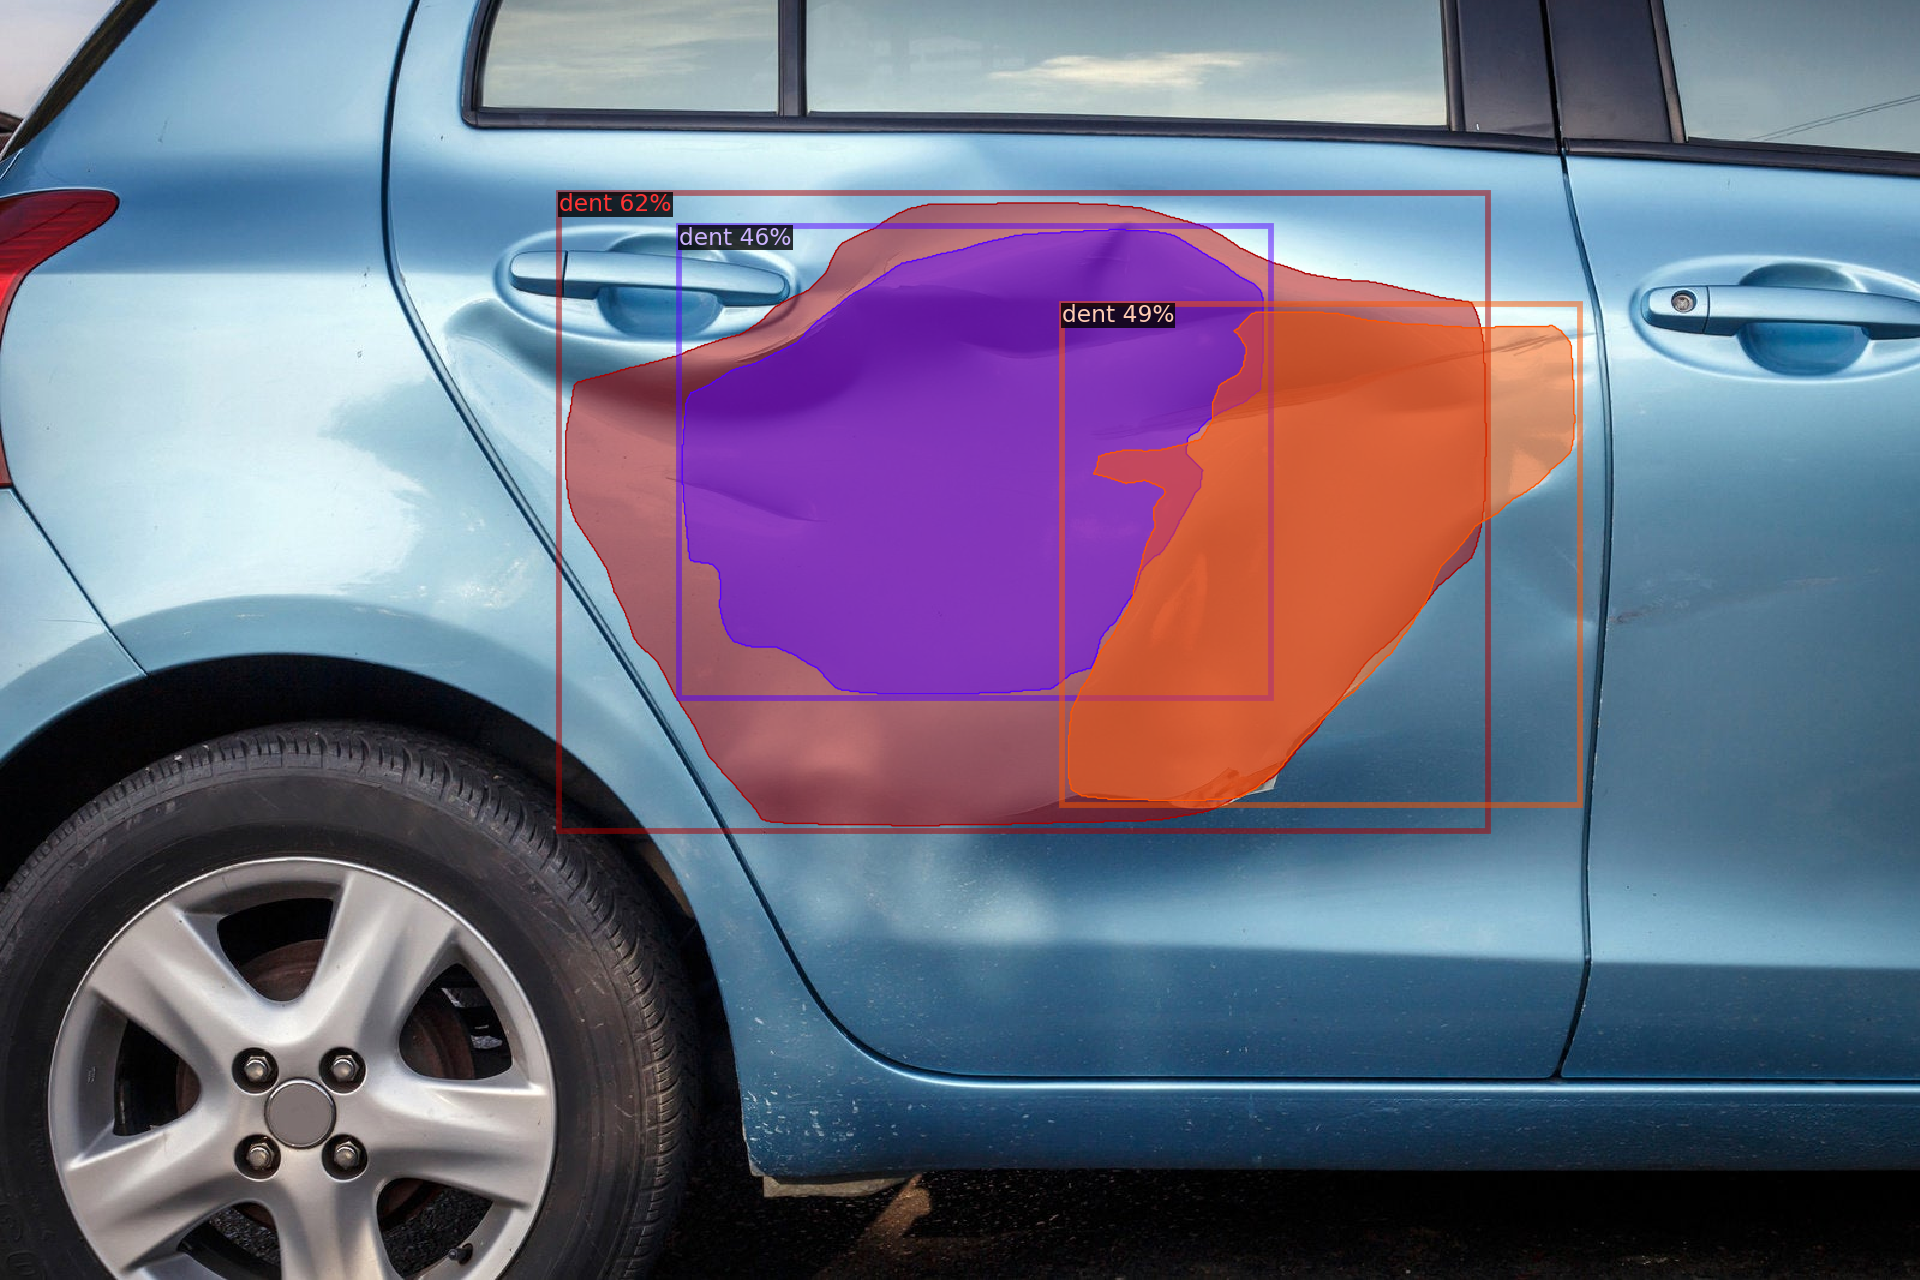

In [ ]:
import detectron2
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2 import model_zoo
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# Define your custom class names here
CUSTOM_CLASS_NAMES = ['dent', 'scratch', 'crack', 'glass shatter', 'lamp broken', 'tire flat']

def register_custom_dataset():
    # Here you should register your custom dataset if it hasn't been registered yet.
    # Since you haven't provided how your dataset is loaded,
    # I will assume it is already registered in DatasetCatalog under "my_dataset_train" and "my_dataset_val"
    for d in ["train", "val"]:
        MetadataCatalog.get(f"my_dataset_{d}").set(thing_classes=CUSTOM_CLASS_NAMES)
    return MetadataCatalog.get("my_dataset_train")

def setup_cfg():
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
    cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/final/model_final.pth"
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(CUSTOM_CLASS_NAMES)
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05  # Set a low threshold to display more predictions
    cfg.DATASETS.TRAIN = ("my_dataset_train",)
    cfg.DATASETS.TEST = ("my_dataset_val",)
    cfg.MODEL.DEVICE = "cpu"
    cfg.freeze()
    return cfg

def load_image(image_path):
    return cv2.imread(image_path)

def predict(image, cfg):
    predictor = DefaultPredictor(cfg)
    return predictor(image)

def filter_predictions_by_confidence(instances, min_confidence, max_confidence):
    confidence_indices = (instances.scores > min_confidence) & (instances.scores <= max_confidence)
    return instances[confidence_indices]

def visualize(image, predictions, metadata):
    v = Visualizer(image[:, :, ::-1], metadata=metadata, scale=1.2)
    v = v.draw_instance_predictions(predictions.to("cpu"))
    result_image = v.get_image()[:, :, ::-1]
    return result_image

def main(image_path):
    cfg = setup_cfg()
    metadata = register_custom_dataset()
    image = load_image(image_path)
    outputs = predict(image, cfg)

    # Get the highest score to set the threshold
    highest_score = outputs['instances'].scores.max().item() if len(outputs['instances']) else 0
    threshold = highest_score * (2/3)  # Calculate 2/3 of the highest score

    # Filter predictions by confidence
    confidence_instances = filter_predictions_by_confidence(outputs['instances'], threshold, 1.0)

    # Visualize the predictions
    result_image = visualize(image, confidence_instances, metadata)

    # Display the image
    cv2_imshow(result_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

if __name__ == "__main__":
    import sys

    # The path to the image file to use for inference
    image_path = "/content/dent_cat.jpeg"
    main(image_path)


In [1]:
!pip install -U typing_extensions
!pip install gradio


Found existing installation: gradio 4.15.0
Uninstalling gradio-4.15.0:
  Successfully uninstalled gradio-4.15.0
  Using cached gradio-4.15.0-py3-none-any.whl (16.6 MB)


In [6]:
import gradio as gr
import detectron2
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2 import model_zoo
import cv2
import numpy as np

# Define your custom class names here
CUSTOM_CLASS_NAMES = ['dent', 'scratch', 'crack', 'glass shatter', 'lamp broken', 'tire flat']

def register_custom_dataset():
    # Register your custom dataset
    for d in ["train", "val"]:
        MetadataCatalog.get(f"my_dataset_{d}").set(thing_classes=CUSTOM_CLASS_NAMES)
    return MetadataCatalog.get("my_dataset_train")

def setup_cfg():
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
    cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/final/model_final.pth"  # Change to your model path
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(CUSTOM_CLASS_NAMES)
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05  # Set threshold
    cfg.DATASETS.TRAIN = ("my_dataset_train",)
    cfg.DATASETS.TEST = ("my_dataset_val",)
    cfg.MODEL.DEVICE = "cpu"
    cfg.freeze()
    return cfg

def visualize(image, predictions, metadata):
    v = Visualizer(image[:, :, ::-1], metadata=metadata, scale=1.2)
    v = v.draw_instance_predictions(predictions.to("cpu"))
    result_image = v.get_image()[:, :, ::-1]
    return result_image
def filter_predictions_by_confidence(instances, min_confidence, max_confidence):
    confidence_indices = (instances.scores > min_confidence) & (instances.scores <= max_confidence)
    return instances[confidence_indices]
def visualize(image, predictions, metadata):
    v = Visualizer(image[:, :, ::-1], metadata=metadata, scale=1.2)
    v = v.draw_instance_predictions(predictions.to("cpu"))
    result_image = v.get_image()[:, :, ::-1]
    return result_image


def predict_image_mask_rcnn(image):
    cfg = setup_cfg()
    metadata = register_custom_dataset()

    # Convert the PIL Image to an OpenCV image
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    predictor = DefaultPredictor(cfg)
    outputs = predictor(image)

    # Get the highest score to set the threshold
    highest_score = outputs['instances'].scores.max().item() if len(outputs['instances']) else 0
    threshold = highest_score * (2/3)  # Calculate 2/3 of the highest score

    # Filter predictions by confidence
    confidence_instances = filter_predictions_by_confidence(outputs['instances'], threshold, 1.0)

    # Visualize the predictions
    result_image = visualize(image, confidence_instances, metadata)
    # Convert the OpenCV image back to PIL format
    result_image = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)
    return result_image

iface = gr.Interface(
    fn=predict_image_mask_rcnn,
    inputs=gr.Image(),
    outputs=gr.Image(),
    title="Mask R-CNN Car Damage Segmentation",
    description="Upload an image to detect and segment car damages using Mask R-CNN."
)

iface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://976d52daf4bcba864b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
